In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random as rd

In [33]:
path = 'StarLightCurves/StarLightCurves_TRAIN.txt'
data_with_label = pd.read_fwf(path, header=None)
data_without_label = data_with_label.iloc[:, 1:]
sample = data_without_label.iloc[0]  # first sample of length 1024
sample = sample.tolist()

In [34]:
sample

[0.53730293,
 0.53110294,
 0.52850294,
 0.52940294,
 0.53360294,
 0.54090293,
 0.55110293,
 0.56400292,
 0.57960292,
 0.59760291,
 0.61790291,
 0.6402029,
 0.66440289,
 0.69040288,
 0.71800287,
 0.74700286,
 0.77730285,
 0.80860284,
 0.84080283,
 0.87370281,
 0.9072028,
 0.94110279,
 0.97520278,
 1.0094028,
 1.0434028,
 1.0772027,
 1.1105027,
 1.1423027,
 1.1730027,
 1.2023027,
 1.2302027,
 1.2564027,
 1.2807027,
 1.3031027,
 1.3235027,
 1.3416026,
 1.3573026,
 1.3707026,
 1.3817026,
 1.3901026,
 1.3960026,
 1.3993026,
 1.4000026,
 1.3982026,
 1.3939026,
 1.3871026,
 1.3779026,
 1.3664026,
 1.3527026,
 1.3370026,
 1.3194027,
 1.3001027,
 1.2792027,
 1.2569027,
 1.2334027,
 1.2089027,
 1.1836027,
 1.1577027,
 1.1313027,
 1.1048027,
 1.0781027,
 1.0517028,
 1.0256028,
 1.0000028,
 0.97510278,
 0.95110279,
 0.92800279,
 0.9062028,
 0.88570281,
 0.86650282,
 0.84890282,
 0.83300283,
 0.81870283,
 0.80610284,
 0.79530284,
 0.78630285,
 0.77910285,
 0.77360285,
 0.76980285,
 0.76770285,
 0.7

In [35]:
len(sample)

1024

In [36]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax

Text(0.5, 1.0, 'Given signal')

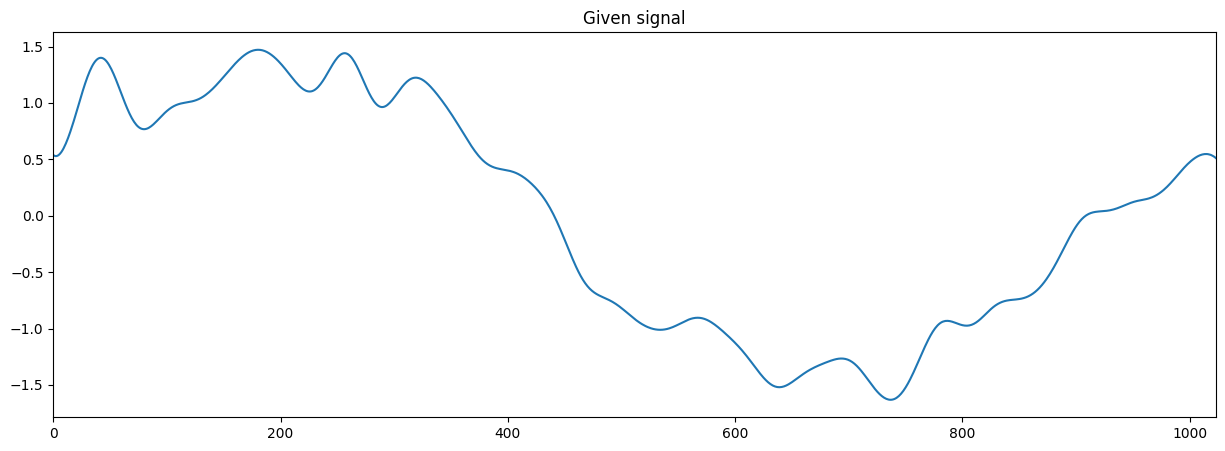

In [37]:
fig, ax = fig_ax()
ax.plot(sample)
plt.title("Given signal")

In [38]:
# Adjust parameters
w = 5
l = 4
c = 3
mean = False

In [39]:
def sliding_windows(sample, w):
    'returns list of the n-w sliding windows of length w of a signal'
    n = len(sample)
    s = []
    for i in range(n-w):
        s.append(sample[i:i+w])
    std=np.std(s) #normalisation
    return s/std

In [40]:
def DFT(sample, l, mean):
    n = len(sample)
    dft = []
    if mean:
        sample=sample-np.mean(sample)
    num = int(round(l/2))
    for u in range(num):
        xu = (1/n) * sum(sample[x]*np.exp(- 2j * np.pi*u*x/n)
                         for x in range(n))
        dft.append(xu.real)
        dft.append(xu.imag)
    return dft

In [41]:
def DFT_A(sample,w, l, mean):
    'returns the matrix A for which each lign i is the DFT of the window i of a signal'
    if mean:
        sample=sample-np.mean(sample)

    num = int(round(l/2))
    windows=sliding_windows(sample,w)
    n = len(sample)

    v=np.exp( 2j * np.pi * np.arange(num) /n)
    V=np.diag(v)
    
    dft0=[]
    for u in range(num):
        xu = (1/w) * sum(sample[x]*np.exp(- 2j * np.pi*u*x/w)
                         for x in range(w))
        dft0.append(xu)

    A=np.array(dft0)
    A=A[np.newaxis,:]
    newcol=np.zeros((1,num))
    for i in range(1,n-w):
        diff=np.ones((1,num))*(sample[i+w]-sample[i])
        newcol= np.dot(A[i-1,:]+diff,V)
        A=np.vstack((A,newcol))
    
    B= np.zeros((A.shape[0],2*num))
    B[:, 0::2] = A.real
    B[:, 1::2] = A.imag
    return B

In [42]:
def MCB(sample, w, l, c, mean):
    windows = sliding_windows(sample, w)
    # A = [DFT(window, l, mean)for window in windows]
    # A = np.array(A)
    A=DFT_A(sample,w,l,mean)
    n, l = A.shape

    breakpoints = []

    for j in range(l):
        sorted_column = np.sort(A[:, j])
        bin_size = n // (c + 1)
        bin_indices = [i * bin_size for i in range(1, c + 1)]
        column_breakpoints = [sorted_column[i] for i in bin_indices]
        breakpoints.append(column_breakpoints)
    return breakpoints, A



In [43]:

def window_to_word(sample, w, l, c, mean):
    breakpoints, A = MCB(sample, w, l, c, mean)
    n, l = A.shape

    alphabet = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
    B_list = []

    for i in range(n):
        row_symbols = []
        for j in range(l):
            column_breakpoints = breakpoints[j]
            bin_index = np.digitize(A[i, j], column_breakpoints, right=True)
            bin_index = min(bin_index, c)
            row_symbols.append(alphabet[bin_index])
        B_list.append(''.join(row_symbols))
    B = np.array(B_list, dtype='<U101')
    return B

In [44]:
def BOSSTransform(sample, w, l, c, mean):
    words = window_to_word(sample, w, l, c, mean)
    unique_words = np.unique(words)
    boss = {value: 0 for value in unique_words}
    lastword = None
    for word in words:
        if word != lastword:
            boss[word] += 1
        lastword = word
    print(boss)
    return boss

In [45]:
def plot_hist(n):
    fig, axs = plt.subplots(n, 2, figsize=(10, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, n))
    for i in range(n):
        sample = data_without_label.iloc[rd.randint(0,len(data_without_label))]  # first sample of length 1024
        sample = sample.tolist()
        boss = BOSSTransform(sample, w, l, c, mean)
        labels = list(boss.keys())
        values = list(boss.values())

        axs[i, 0].plot(sample, color=colors[i])
        axs[i, 0].set_xlabel('Temps')
        axs[i, 0].set_ylabel('Amplitude')
        axs[i, 0].set_title('Signal')

        axs[i, 1].bar(labels, values, color=colors[i])
        axs[i, 1].set_xlabel('Mot')
        axs[i, 1].set_ylabel('Fréquence')
        axs[i, 1].set_title('Histogramme des fréquences des mots')
        axs[i, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

{'AAAA': 1, 'AAAB': 1, 'AABA': 1, 'AACA': 1, 'BAAB': 1, 'BAAC': 1, 'BACA': 1, 'BADA': 1, 'BADB': 1, 'BADC': 1, 'CAAC': 1, 'CAAD': 1, 'CABB': 1, 'CABC': 1, 'CABD': 1, 'CACC': 1, 'CADC': 1, 'CADD': 1, 'DABD': 1, 'DACC': 1, 'DACD': 1}
{'AAAB': 2, 'AAAC': 2, 'AAAD': 2, 'AABA': 1, 'AABB': 2, 'AABC': 2, 'AACA': 2, 'AACB': 3, 'AACC': 1, 'BAAA': 1, 'BAAB': 1, 'BAAC': 2, 'BAAD': 3, 'BABA': 3, 'BABB': 1, 'BABC': 2, 'BABD': 1, 'BACA': 2, 'BACB': 4, 'BACC': 1, 'CAAA': 1, 'CAAB': 1, 'CAAC': 1, 'CABA': 3, 'CABC': 1, 'CABD': 1, 'CACA': 2, 'CACB': 2, 'CACC': 3, 'CACD': 1, 'CADA': 1, 'CADB': 1, 'CADC': 2, 'CADD': 1, 'DABA': 1, 'DACA': 1, 'DACC': 1, 'DADA': 2, 'DADB': 3, 'DADC': 3, 'DADD': 1}
{'AAAA': 1, 'AAAB': 1, 'AABA': 2, 'AACA': 1, 'BAAB': 1, 'BAAC': 1, 'BAAD': 1, 'BABA': 1, 'BACA': 2, 'BACB': 1, 'BADA': 1, 'BADB': 1, 'CAAD': 1, 'CABB': 3, 'CABC': 1, 'CABD': 1, 'CACD': 1, 'CADB': 1, 'CADC': 1, 'CADD': 1, 'DABB': 2, 'DABC': 2, 'DABD': 1, 'DACC': 2, 'DACD': 1}
{'AAAA': 1, 'AAAB': 1, 'AABA': 1, 'AACA'

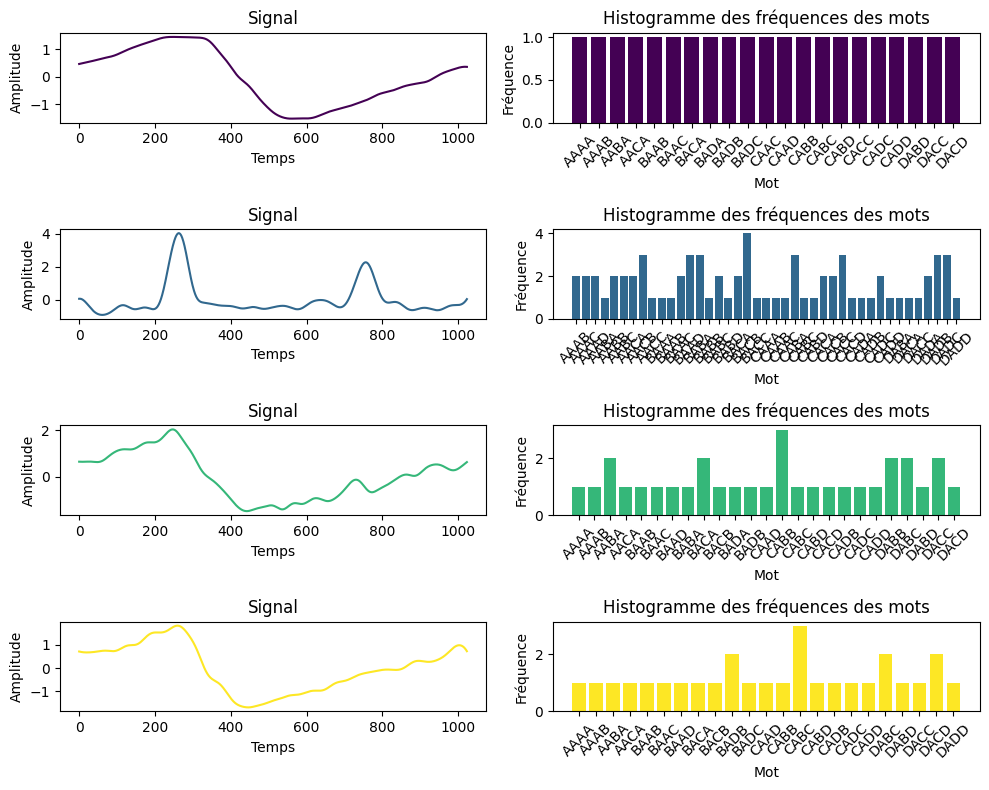

In [46]:

plot_hist(4)


In [47]:
# Algo 2
def boss_distance(h1,h2):
    dist=0
    for word in h1.keys():
        if word in h2.keys():
            dist+=(h1[word]-h2[word])**2
        else:
            dist+=h1[word]**2
    return dist

In [19]:

def TS_predict(test, samples, w,l,c):
    bestDist=np.inf
    bestTs=None
    n=len(samples)
    h= BOSSTransform(test, w, l, c, mean=False)
    for i in range(n):
        signal=samples.iloc[i]
        hi=BOSSTransform(signal, w, l, c, mean=False)
        dist=boss_distance(h,hi)
        if dist < bestDist:
            bestDist = dist
            bestTs = signal
    return bestTs

In [24]:
path = 'StarLightCurves/StarLightCurves_TRAIN.txt'
data_with_label = pd.read_fwf(path, header=None)
data_without_label = data_with_label.iloc[:, 1:]
sample1 = data_without_label.iloc[0]
sample2 = data_without_label.iloc[1]

print(TS_predict(sample1,data_without_label,w,l,c))

KeyError: 0

In [26]:
histogram = {'AAA':1, 'AAB':0, 'ABA':1, 'ABB':0, 'BAA':1, 'BAB':2, 'BBA':2, 'BBB':2}

In [24]:
def shortenHistogram(hist,f):
    current_histogram = hist
    current_words = list(current_histogram.keys())
    while f < len(current_words[0]):
        new_histogram = {}
        current_words = list(current_histogram.keys())
        for word in current_words:
            if word[:-1] not in new_histogram.keys():
                new_histogram[word[:-1]] = current_histogram[word]
            else:
                new_histogram[word[:-1]] += current_histogram[word]
        current_histogram = new_histogram
        current_words = list(current_histogram.keys())
        # print(current_histogram)
    return current_histogram

In [31]:
shortenHistogram(histogram,1)

{'AA': 1, 'AB': 1, 'BA': 3, 'BB': 4}
{'A': 2, 'B': 7}


{'A': 2, 'B': 7}

In [ ]:
# Algo 3
def fit(samples,labels,mean):
    hist = []
    scores = []
    maxF = 16
    minSize = 10
    maxSize = len(samples)
    c = 4
    for w in range(maxSize, minSize-1, -1):
        for i in range(len(samples)):
            hist.append(BOSSTransform(samples[i],w,maxF,c,mean))
        bestCor = 0
        bestF = 0
        for f in range(8,maxF+1,2):
            histShort = shortenHistogram(hist, f)
            correct = 0
            for qId in range(len(samples)):
                # Remove samples[qId] from samples
                best = TS_predict(qId, samples/samples[qId],histShort)
                if labels(best) == labels(samples):
                    correct += 1
            if correct > bestCor:
                bestCor = correct
                bestF = f
        scores.append((correct,w,bestF,hist))
    return scores


In [ ]:
# Algo 4
def predictEnsemble(qId,samples,windowScores):
    windowLabels = []
    maxCorrect = max(correct for (correct,_,_,_) in windowScores)
    for (correct,_,_,histograms) in windowScores:
        if (correct > maxCorrect * FACTOR):
            windowLabels[len] = labels(predict(qId,samples,histograms))
    return 